In [1]:
import os 

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pydiffvg
from segmentation_models_pytorch.losses import DiceLoss
import torch
from torch import nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from tqdm import tqdm

/home/user20/miniconda3/envs/diffvg2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.__version__

'2.4.0+cu124'

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda:1")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

using device: cuda:1


In [4]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([87/255, 186/255, 168/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [5]:
image = Image.open('../images/DAVIS/img/070.jpg')
image = np.array(image.convert("RGB"))
image.shape

(480, 854, 3)

In [6]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../../checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)
for param in predictor.model.parameters():
    param.requires_grad = False

/home/user20/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [7]:
predictor.set_image(image)

In [8]:
gt_mask = Image.open('../images/DAVIS/gt/070.png')
gt_mask_np = np.where(np.array(gt_mask) > 0, 1.0, 0.0)
tensor_transform = ToTensor()
gt_mask = tensor_transform(gt_mask_np)

In [9]:
input_point = np.array([[470, 195]])
input_label = np.array([1])

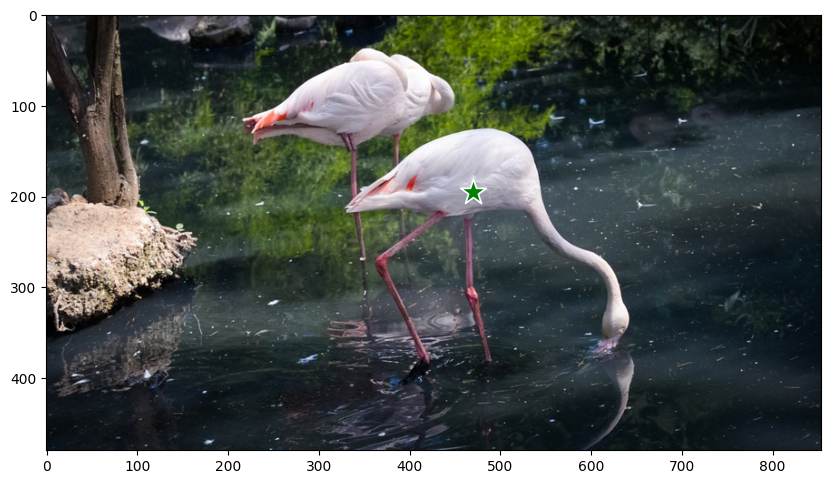

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

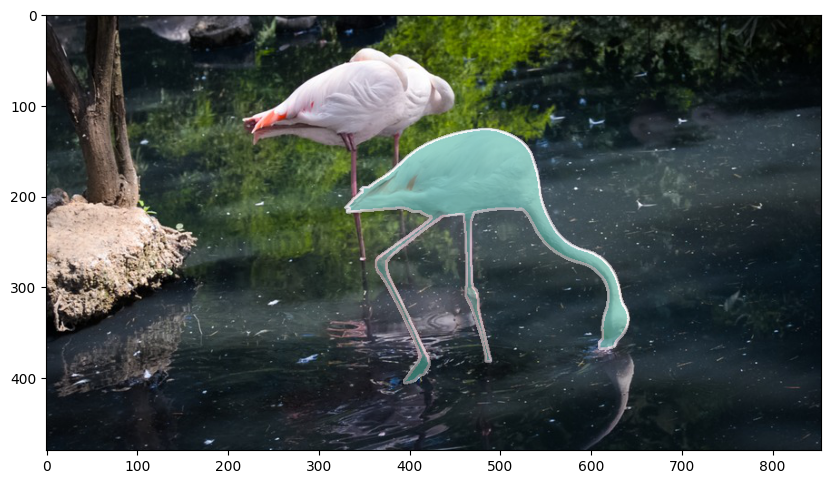

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(gt_mask_np, ax=plt)
plt.axis('on')
plt.show()

In [12]:
image.shape

(480, 854, 3)

In [13]:
mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
    input_point, input_label, box=None, mask_logits=None, normalize_coords=True
)

In [14]:
unnorm_coords

tensor([[[563.5597, 416.0000]]], device='cuda:1')

In [15]:
unnorm_coords.requires_grad = True

In [16]:
unnorm_coords

tensor([[[563.5597, 416.0000]]], device='cuda:1', requires_grad=True)

In [17]:
mask, scores, low_res_masks = predictor._predict(
    unnorm_coords,
    labels,
    unnorm_box,
    mask_input,
    multimask_output=False,
    return_logits=True
)

In [18]:
mask.float()

tensor([[[[-12.1992, -12.1992, -13.0533,  ..., -15.0432, -15.4342, -15.4342],
          [-12.9148, -12.9148, -13.4060,  ..., -15.0984, -15.1851, -15.1851],
          [-14.1869, -14.1869, -14.0328,  ..., -15.1965, -14.7424, -14.7424],
          ...,
          [-14.9757, -14.9757, -15.1805,  ..., -12.7171, -11.9711, -11.9711],
          [-14.8067, -14.8067, -14.8705,  ..., -12.6130, -12.4369, -12.4369],
          [-14.7116, -14.7116, -14.6961,  ..., -12.5545, -12.6989, -12.6989]]]],
       device='cuda:1', grad_fn=<UpsampleBilinear2DBackward0>)

In [19]:
def build_field(gt_mask, prev_mask):
    gt_8_bit = gt_mask[0][0].detach().numpy().astype(np.uint8)
    prev_mask_8_bit = (prev_mask[0].detach().cpu().numpy() > 0.5)[0].astype(np.uint8)
    
    gt_mask_dt_for_positive = cv2.distanceTransform(1 - (gt_8_bit - (gt_8_bit & prev_mask_8_bit)), cv2.DIST_L2, 0)
    gt_mask_dt_for_negative =  cv2.distanceTransform(gt_8_bit | (1 - prev_mask_8_bit), cv2.DIST_L2, 0)

    gt_mask_dt_for_positive = torch.from_numpy(gt_mask_dt_for_positive).to(device)
    gt_mask_dt_for_negative =  torch.from_numpy(gt_mask_dt_for_negative).to(device)
    
    return gt_mask_dt_for_positive, gt_mask_dt_for_negative

In [20]:
norm_radius = 5

def rasterize(last_point, last_label):
    x, y = last_point[0][0]
    rows, cols = 1024, 1024

    x = torch.clamp(x + 0.5, 0, cols - 1)
    y = torch.clamp(y + 0.5, 0, rows - 1)

    last_clamp = torch.stack([x, y])

    circle = pydiffvg.Circle(radius = torch.tensor(norm_radius), center = last_clamp)
    circle_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([0]), fill_color = torch.tensor([1, 0, 0, 1.0]))
    scene_args = pydiffvg.RenderFunction.serialize_scene(cols, rows, [circle], [circle_group])
    img_rendered = pydiffvg.RenderFunction.apply(cols, # width
                                rows, # height
                                2,   # num_samples_x
                                2,   # num_samples_y
                                0,   # seed
                                None, # background_image
                                *scene_args)[:, :, 0]

    img_opposite = torch.zeros_like(img_rendered)
    if last_label[0] == 0:
        coords_new = torch.stack([img_opposite, img_rendered])[None]
    else:
        coords_new = torch.stack([img_rendered, img_opposite])[None]

    return coords_new.to(device)

In [21]:
def get_reg_loss(gt_mask_dt_for_positive, gt_mask_dt_for_negative, coords_new):
    gt_mask_dt_for_positive_resized = nn.functional.interpolate(gt_mask_dt_for_positive[None, None], size=coords_new.shape[2:], mode='bilinear', align_corners=True)
    gt_mask_dt_for_negative_resized = nn.functional.interpolate(gt_mask_dt_for_negative[None, None], size=coords_new.shape[2:], mode='bilinear', align_corners=True)

    # Two distance transforms for interaction location loss
    positive_selected = (coords_new[0][0] * gt_mask_dt_for_positive_resized[0][0])
    negative_selected = (coords_new[0][1] * gt_mask_dt_for_negative_resized[0][0])
    regularization_loss = positive_selected.mean() + negative_selected.mean()
    
    return regularization_loss

In [22]:
def get_iou(gt_mask, pred_mask, ignore_label=-1):
    ignore_gt_mask_inv = gt_mask != ignore_label
    obj_gt_mask = gt_mask == 1

    intersection = np.logical_and(np.logical_and(pred_mask, obj_gt_mask), ignore_gt_mask_inv).sum()
    union = np.logical_and(np.logical_or(pred_mask, obj_gt_mask), ignore_gt_mask_inv).sum()

    return intersection / union

In [23]:
unnorm_coords

tensor([[[563.5597, 416.0000]]], device='cuda:1', requires_grad=True)

In [24]:
iters = 80
lambda_reg = 0.01

predictor.set_image(image)
mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
    input_point,
    input_label,
    box=None,
    mask_logits=None,
    normalize_coords=True
)

adv_mask = gt_mask.unsqueeze(dim=0).to(device)

MODE = 'MAX'
output_folder = 'point_prompt_output_' + MODE
os.makedirs(output_folder, exist_ok=True)
unnorm_coords[0][0][0] = unnorm_coords[0][0][0]  / 1024
unnorm_coords[0][0][1] = unnorm_coords[0][0][1]  / 1024
unnorm_coords.requires_grad = True

opt = optim.Adam([unnorm_coords], lr=1e-2)

dice_loss = DiceLoss('binary', from_logits=True)
losses = []

prev_mask = torch.zeros_like(mask)
for iter in tqdm(range(iters)):
        
    opt.zero_grad()

    unnorm_coords_full = unnorm_coords.clone()
    unnorm_coords_full = unnorm_coords_full.clamp(0, 1)

    unnorm_coords_full[0][0][0] = unnorm_coords_full[0][0][0] * 1024
    unnorm_coords_full[0][0][1] = unnorm_coords_full[0][0][1] * 1024

    mask, scores, low_res_masks = predictor._predict(
        unnorm_coords_full,
        labels,
        unnorm_box,
        mask_input,
        multimask_output=False,
        return_logits=True
    )
    
    iou_score = get_iou(adv_mask[0][0].detach().cpu().numpy(), (mask[0][0].detach().cpu().numpy() > 0))
    
    coords_new = rasterize(unnorm_coords_full, input_label)
    gt_mask_dt_for_positive, gt_mask_dt_for_negative = build_field(gt_mask, prev_mask)
    reg_loss = get_reg_loss(gt_mask_dt_for_positive, gt_mask_dt_for_negative, coords_new)
   
    main_loss = dice_loss(mask, adv_mask) * (1 if MODE == 'MAX' else - 1)
    loss = main_loss + lambda_reg * reg_loss
    losses.append(loss.item())
    
    if iter % 10 == 0 or iter == iters - 1:
        print(loss)
        print(iou_score)
        print(unnorm_coords)
    
    input_point = np.array([[unnorm_coords.detach().cpu().numpy()[0][0][0] * image.shape[1], 
                                unnorm_coords.detach().cpu().numpy()[0][0][1] * image.shape[0]]])
    input_label = np.array([1])
    
    plt.figure(figsize=(10, 10))
    ax = plt.gca() 
    plt.imshow(image)
    ax.cla()
    ax.imshow(image)
    show_points(input_point, input_label, plt.gca())
    show_mask((mask[0][0].detach().cpu().numpy() > 0), ax=plt)
    plt.title(f"Iter: {iter}, IoU: {round(iou_score, 3)}, Mode: {MODE} IoU")
    plt.savefig(os.path.join(output_folder, f'mask_iter_{iter}.png'))
                
    loss.backward(retain_graph=True)
    opt.step()
    


  0%|          | 0/80 [00:00<?, ?it/s]

tensor(0.1116, device='cuda:1', grad_fn=<AddBackward0>)
0.9299687193613148
tensor([[[0.5504, 0.4063]]], device='cuda:1', requires_grad=True)


 12%|█▎        | 10/80 [00:06<00:42,  1.65it/s]

tensor(0.1043, device='cuda:1', grad_fn=<AddBackward0>)
0.9366711646735842
tensor([[[0.5682, 0.3170]]], device='cuda:1', requires_grad=True)


 25%|██▌       | 20/80 [00:12<00:40,  1.49it/s]/tmp/ipykernel_1338081/965994830.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 10))


tensor(0.1045, device='cuda:1', grad_fn=<AddBackward0>)
0.9366858950502419
tensor([[[0.5641, 0.3119]]], device='cuda:1', requires_grad=True)


 38%|███▊      | 30/80 [00:18<00:30,  1.65it/s]

tensor(0.1046, device='cuda:1', grad_fn=<AddBackward0>)
0.9369616835048187
tensor([[[0.5705, 0.3331]]], device='cuda:1', requires_grad=True)


 50%|█████     | 40/80 [00:24<00:24,  1.64it/s]

tensor(0.1052, device='cuda:1', grad_fn=<AddBackward0>)
0.9368019359642591
tensor([[[0.5640, 0.3199]]], device='cuda:1', requires_grad=True)


 61%|██████▏   | 49/80 [00:30<00:19,  1.61it/s]

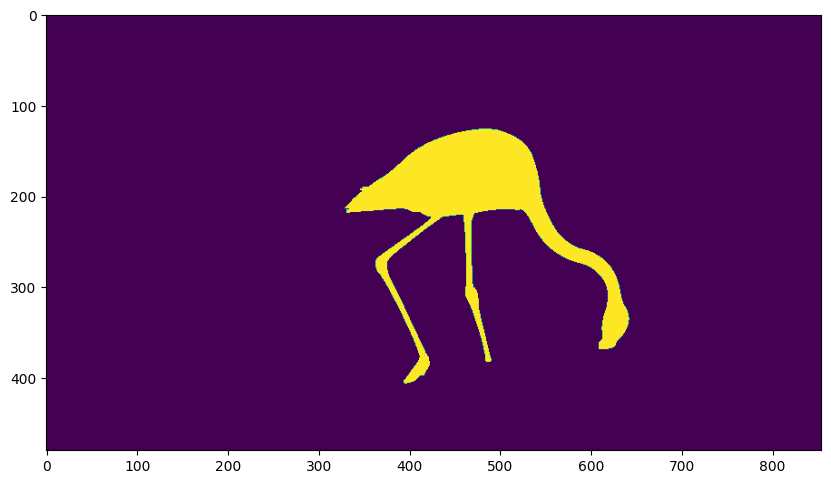

In [292]:
plt.figure(figsize=(10, 10))
plt.imshow(adv_mask[0][0].detach().cpu().numpy() > 0)
plt.show()

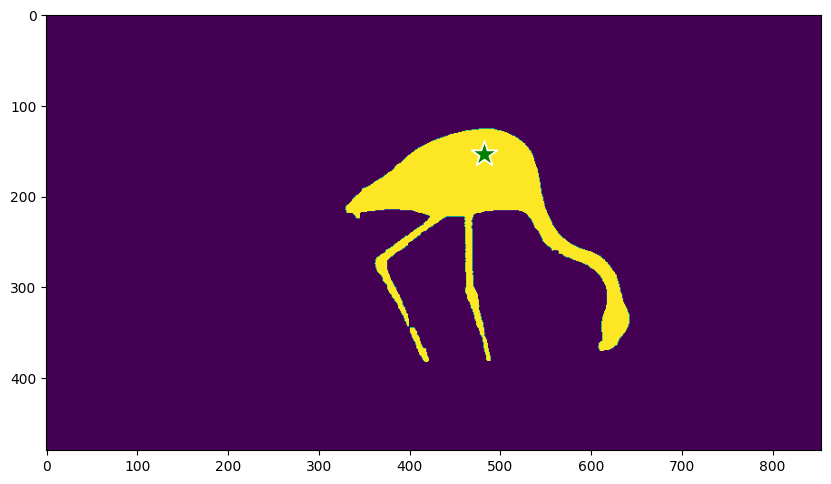

In [293]:
plt.figure(figsize=(10, 10))
plt.imshow(mask[0][0].detach().cpu().numpy() > 0)
input_point = np.array([[unnorm_coords.detach().cpu().numpy()[0][0][0] * image.shape[1], 
                         unnorm_coords.detach().cpu().numpy()[0][0][1] * image.shape[0]]])
input_label = np.array([1])
show_points(input_point, input_label, plt.gca())
plt.show()

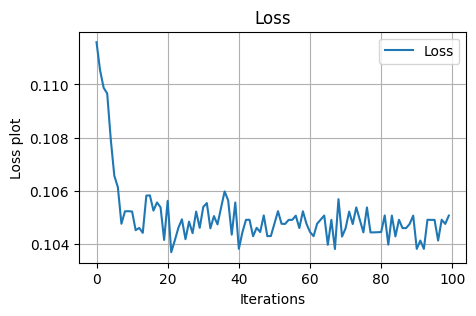

In [294]:
plt.figure(figsize=(5, 3))
plt.plot(losses, label='Loss')
plt.title('Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss plot')
plt.grid(True)
plt.legend()
plt.show()

In [295]:
# зелененькая маска 
# синяя звезда
# iou выводить 

# для максимизации взять сложный обьект 